In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append("../")
from src.preprocessing import load_and_split_data, scale_data
import joblib

In [2]:
data_path = '../Data/engine_data.csv'
df = pd.read_csv(data_path)

In [3]:
print("Information of dataset :")
df.info()

Information of dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


In [4]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
1         876          2.941606      16.193866          2.464504   
2         520          2.961746       6.553147          1.064347   
3         473          3.707835      19.510172          3.727455   
4         619          5.672919      15.738871          2.052251   

   lub oil temp  Coolant temp  Engine Condition  
0     84.144163     81.632187                 1  
1     77.640934     82.445724                 0  
2     77.752266     79.645777                 1  
3     74.129907     71.774629                 1  
4     78.396989     87.000225                 0  


In [5]:
df.isnull().sum()

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
Engine Condition    0
dtype: int64

In [6]:
df.describe()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       4.916886          1.600466   
50%      746.000000          3.162035       6.201720          2.166883   
75%      934.000000          4.055272       7.744973          2.848840   
max     2239.000000          7.265566      21.138326          7.478505   

       lub oil temp  Coolant temp  Engine Condition  
count  19535.000000  19535.000000      19535.000000  
mean      77.643420     78.427433          0.630509  
std        3.110984      6.206749          0.482679  
min       71.321974     61.673325          0.000000  
25%       75.725990     73.895421          0.000000  
50%       76.817350     78.346662          1.000000  
75%       78.071691     82.915411          1.000000  
max       89.580796    195.527912          1.000000

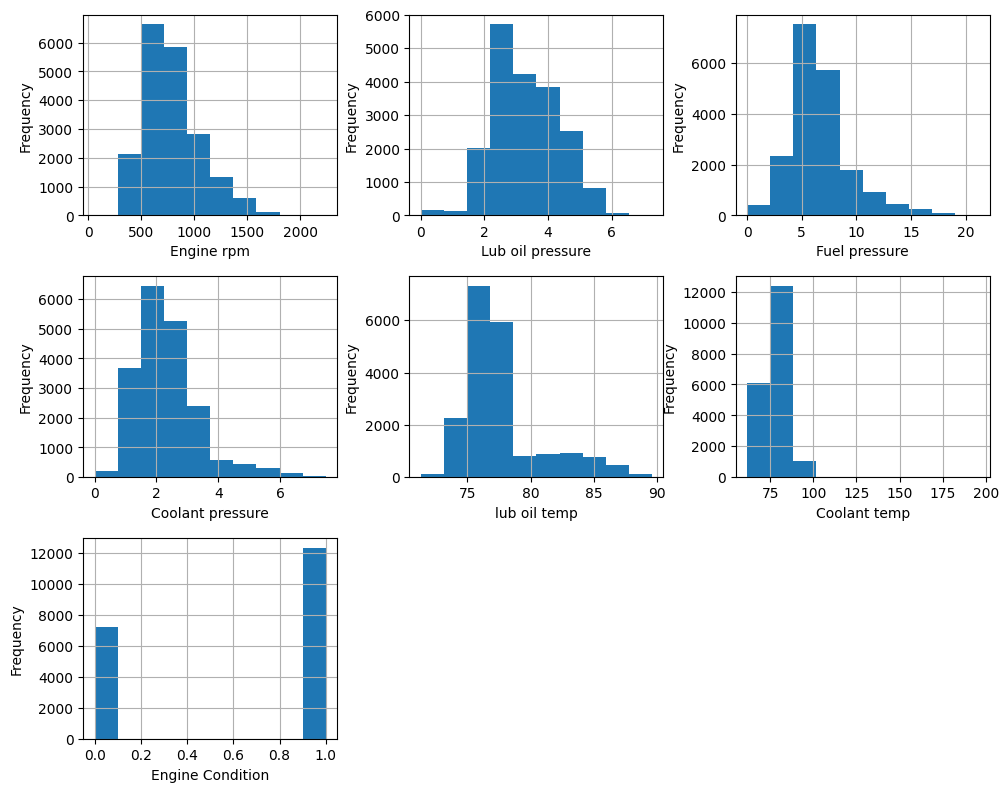

In [7]:
import matplotlib.pyplot as plt

axes = df.hist(figsize=(10, 8))
plt.tight_layout()

for ax in axes.flatten():
    ax.set_xlabel(ax.get_title())
    ax.set_ylabel('Frequency')
    ax.set_title('')  # Remove redundant titles

plt.show()

In [8]:
df['Engine Condition'].value_counts()

Engine Condition
1    12317
0     7218
Name: count, dtype: int64

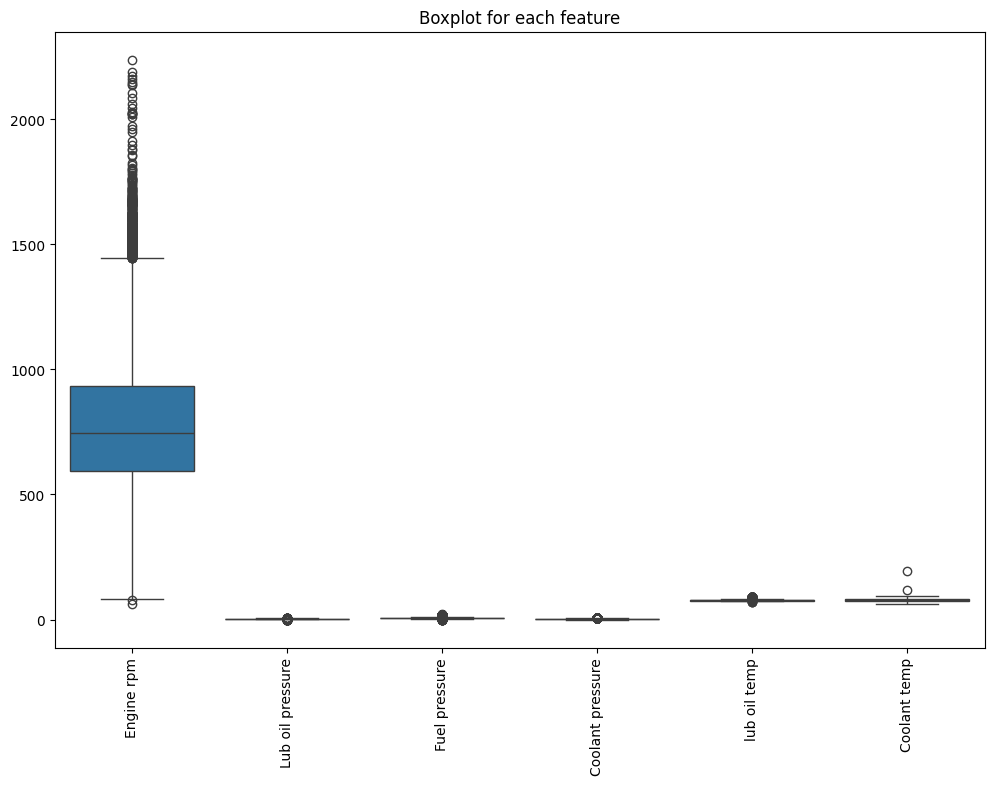

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for each feature to check for outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop('Engine Condition', axis=1))  # Exclude target column
plt.xticks(rotation=90)
plt.title('Boxplot for each feature')
plt.show()

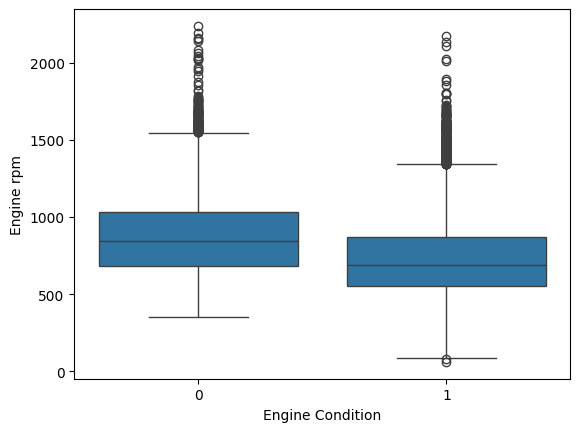

In [10]:
sns.boxplot(x='Engine Condition', y='Engine rpm', data=df)
plt.show()

In [11]:
# Calculate IQR for each feature
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((df < lower_bound) | (df > upper_bound)).sum()
print("Outliers per feature:")
print(outliers)

Outliers per feature:
Engine rpm           464
Lub oil pressure      66
Fuel pressure       1135
Coolant pressure     785
lub oil temp        2617
Coolant temp           2
Engine Condition       0
dtype: int64


Checking outlier values

In [12]:
# Find and display outlier values for each feature
for col in df.columns:
    if col != 'Engine Condition':  # Skip target if desired
        outlier_mask = (df[col] < lower_bound[col]) | (df[col] > upper_bound[col])
        outlier_values = df.loc[outlier_mask, col]
        print(f"Outliers in {col}:")
        print(outlier_values)
        print('-' * 40)

Outliers in Engine rpm:
55       1674
88       1776
102      1481
108      1661
143      1620
         ... 
19241    2136
19357    1556
19409    1586
19447    1807
19466    1579
Name: Engine rpm, Length: 464, dtype: int64
----------------------------------------
Outliers in Lub oil pressure:
397      0.143225
440      6.458110
587      0.072615
632      0.189372
649      0.158712
           ...   
18055    0.192741
18206    0.139910
18296    0.040510
18321    0.060044
18336    6.575457
Name: Lub oil pressure, Length: 66, dtype: float64
----------------------------------------
Outliers in Fuel pressure:
1        16.193866
3        19.510172
4        15.738871
29       13.971160
32       12.311909
           ...    
19425    12.085800
19447    14.140429
19474    12.948286
19515    14.372844
19524    14.660847
Name: Fuel pressure, Length: 1135, dtype: float64
----------------------------------------
Outliers in Coolant pressure:
53       5.694339
70       5.261252
80       4.853973
188   

In [13]:
# Remove outliers based on IQR bounds
cleaned_df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Check the shape of the new dataset
print(f"Original data shape: {df.shape}")
print(f"Data after removing outliers: {cleaned_df.shape}")

Original data shape: (19535, 7)
Data after removing outliers: (14899, 7)


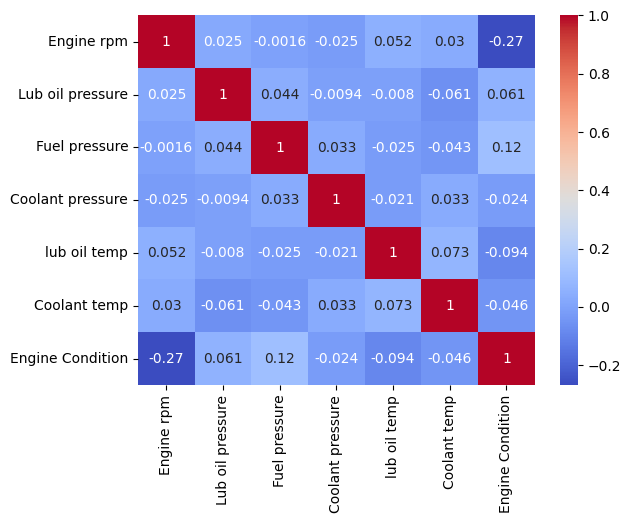

In [14]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

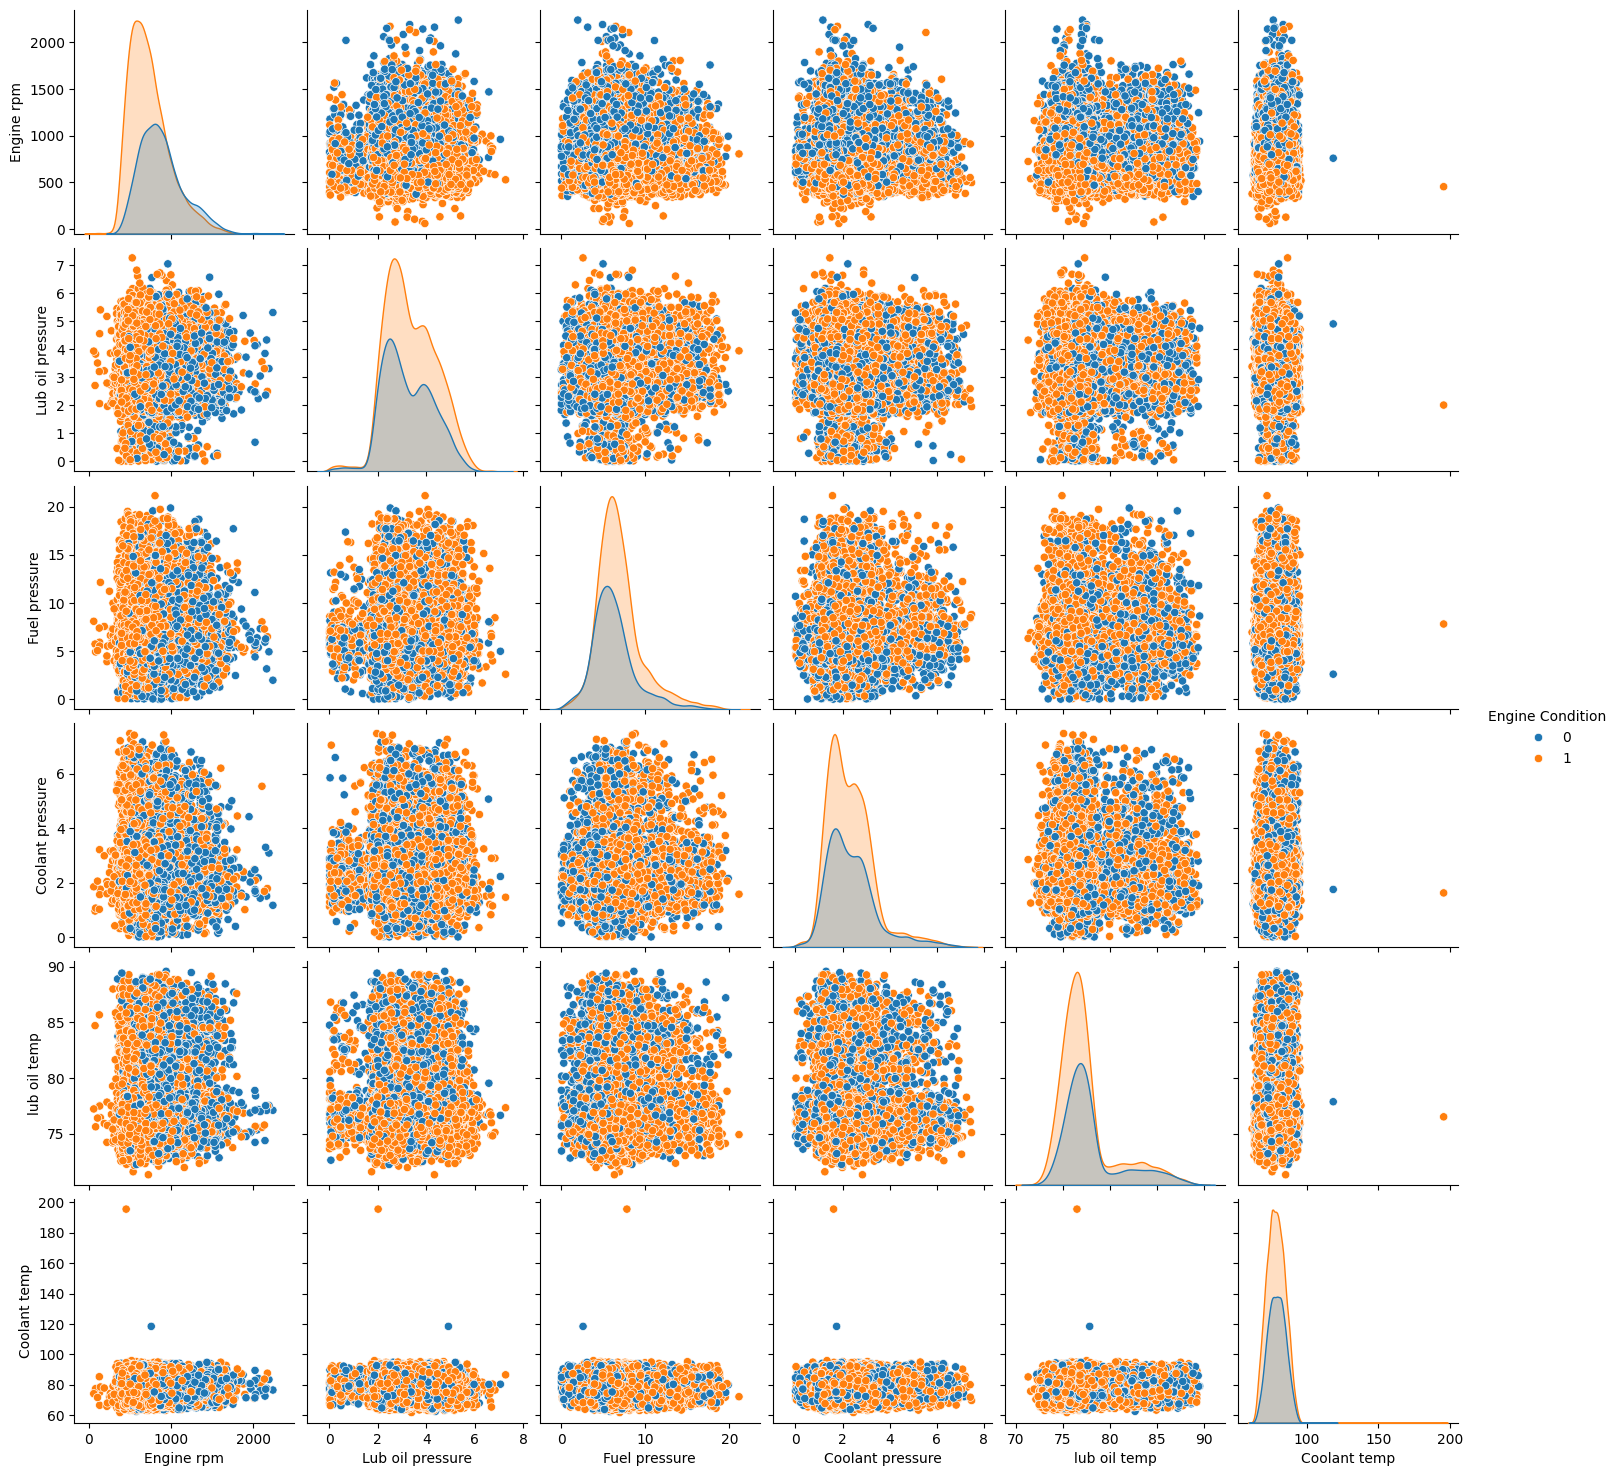

In [15]:
sns.pairplot(df, hue='Engine Condition')
plt.show()

In [16]:
# Define features (X) and target (y)
X = cleaned_df.drop('Engine Condition', axis=1)  # Drop target column from features
y = cleaned_df['Engine Condition']  # The target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (11919, 6)
Testing set size: (2980, 6)


Scaling the data

In [17]:
X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)

# Feature Engineering

In [ ]:
# Create copies to work with, to avoid modifying the original cleaned_df directly in subsequent steps
df_engineered = cleaned_df.copy()

# 1. Pressure Ratios
# These can indicate imbalances or inefficiencies.
df_engineered['Fuel_Lub_Pressure_Ratio'] = df_engineered['Fuel pressure'] / df_engineered['Lub oil pressure']
df_engineered['Coolant_Fuel_Pressure_Ratio'] = df_engineered['Coolant pressure'] / df_engineered['Fuel pressure']

# 2. Temperature Difference
# A large difference could indicate cooling system issues or excessive lubrication heating.
df_engineered['Lub_Coolant_Temp_Diff'] = df_engineered['lub oil temp'] - df_engineered['Coolant temp']

# 3. RPM-Pressure Interaction (Product)
# High RPM with abnormal pressures might be particularly indicative of stress.
df_engineered['RPM_Lub_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Lub oil pressure']
df_engineered['RPM_Fuel_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Fuel pressure']

print("\nFirst 5 rows with new engineered features:")
print(df_engineered.head())


First 5 rows with new engineered features:
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
2         520          2.961746       6.553147          1.064347   
5        1221          3.989226       6.679231          2.214250   
7         729          3.845166      10.191126          2.362998   
8         845          4.877239       3.638269          3.525604   
9         824          3.741228       7.626214          1.301032   

   lub oil temp  Coolant temp  Engine Condition  Fuel_Lub_Pressure_Ratio  \
2     77.752266     79.645777                 1                 2.212596   
5     76.401152     75.669818                 0                 1.674317   
7     77.921202     71.671761                 1                 2.650374   
8     76.301626     70.496024                 0                 0.745969   
9     77.066520     85.143297                 0                 2.038425   

   Coolant_Fuel_Pressure_Ratio  Lub_Coolant_Temp_Diff  \
2                     0.162418   

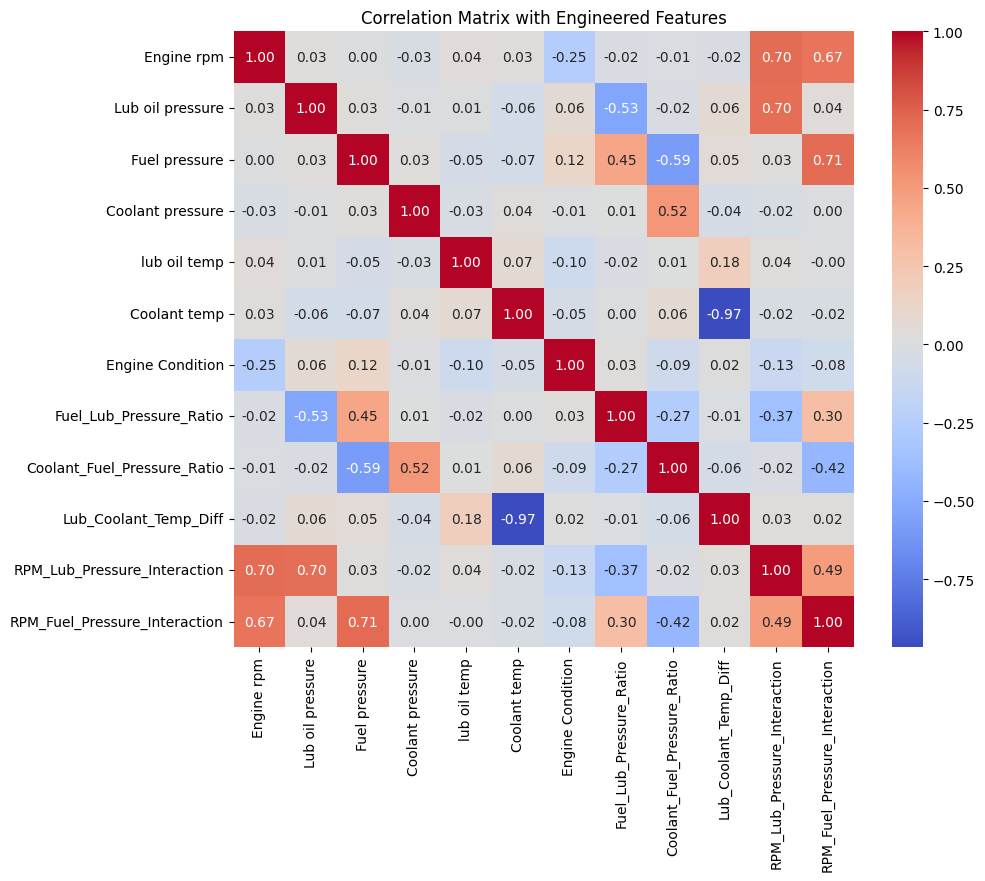


Correlation of Engineered Features with Engine Condition:
Engine Condition                 1.000000
Fuel pressure                    0.123041
Lub oil pressure                 0.063993
Fuel_Lub_Pressure_Ratio          0.030703
Lub_Coolant_Temp_Diff            0.020311
Coolant pressure                -0.006571
Coolant temp                    -0.045337
RPM_Fuel_Pressure_Interaction   -0.079331
Coolant_Fuel_Pressure_Ratio     -0.089473
lub oil temp                    -0.096557
RPM_Lub_Pressure_Interaction    -0.126586
Engine rpm                      -0.252295
Name: Engine Condition, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = df_engineered.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Engineered Features')
plt.show()

print("\nCorrelation of Engineered Features with Engine Condition:")
print(correlation_matrix['Engine Condition'].sort_values(ascending=False))

First 5 rows of scaled data:
   Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
2   -1.043200         -0.347564       0.154314         -1.414541   
5    1.896437          0.668681       0.216029          0.009011   
7   -0.166760          0.526196       1.935011          0.193157   
8    0.319685          1.546985      -1.272444          1.632435   
9    0.231621          0.423396       0.679553         -1.121531   

   lub oil temp  Coolant temp  Fuel_Lub_Pressure_Ratio  \
2      0.738161      0.223850                 0.060326   
5     -0.122913     -0.424800                -0.303496   
7      0.845825     -1.077054                 0.356218   
8     -0.186341     -1.268867                -0.930964   
9      0.301131      1.120731                -0.057396   

   Coolant_Fuel_Pressure_Ratio  Lub_Coolant_Temp_Diff  \
2                    -0.885712              -0.034368   
5                    -0.273979               0.387460   
7                    -0.634462            

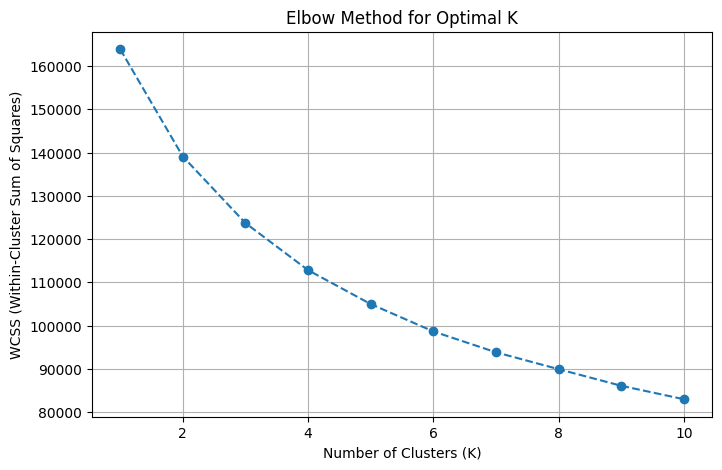

Silhouette Score for K=2: 0.1592
Silhouette Score for K=3: 0.1416
Silhouette Score for K=4: 0.1366
Silhouette Score for K=5: 0.1408
Silhouette Score for K=6: 0.1444
Silhouette Score for K=7: 0.1306
Silhouette Score for K=8: 0.1246
Silhouette Score for K=9: 0.1261
Silhouette Score for K=10: 0.1276


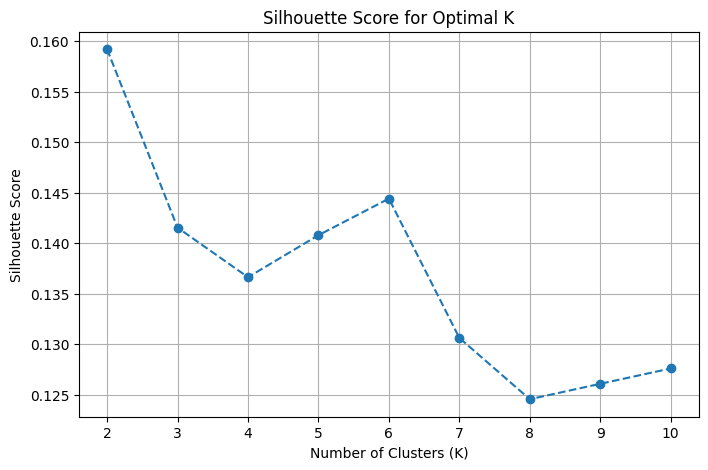

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Identify features for clustering (all numerical features except 'Engine Condition')
features_for_clustering = df_engineered.drop(columns=['Engine Condition']).columns

X = df_engineered[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering, index=df_engineered.index)

print("First 5 rows of scaled data:")
print(X_scaled_df.head())

# Determining Optimal Number of Clusters (k)

# Elbow Method
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10) 
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={i}: {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

# Create engineered features on cleaned_df
df_engineered = cleaned_df.copy()
df_engineered['Fuel_Lub_Pressure_Ratio'] = df_engineered['Fuel pressure'] / df_engineered['Lub oil pressure']
df_engineered['Coolant_Fuel_Pressure_Ratio'] = df_engineered['Coolant pressure'] / df_engineered['Fuel pressure']
df_engineered['Lub_Coolant_Temp_Diff'] = df_engineered['lub oil temp'] - df_engineered['Coolant temp']
df_engineered['RPM_Lub_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Lub oil pressure']
df_engineered['RPM_Fuel_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Fuel pressure']

# Define features (X) and target (y)
X = df_engineered.drop('Engine Condition', axis=1)
y = df_engineered['Engine Condition']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"Training set size (scaled): {X_train_scaled_df.shape}")
print(f"Testing set size (scaled): {X_test_scaled_df.shape}")

Training set size (scaled): (11919, 11)
Testing set size (scaled): (2980, 11)


In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled_df, y_train)

print("Model training complete.")

Model training complete.



Feature Importances:
                          Feature  Importance
0                      Engine rpm    0.134184
4                    lub oil temp    0.100808
2                   Fuel pressure    0.095443
1                Lub oil pressure    0.089982
10  RPM_Fuel_Pressure_Interaction    0.088692
9    RPM_Lub_Pressure_Interaction    0.088351
7     Coolant_Fuel_Pressure_Ratio    0.082504
3                Coolant pressure    0.081357
5                    Coolant temp    0.079859
6         Fuel_Lub_Pressure_Ratio    0.079833
8           Lub_Coolant_Temp_Diff    0.078987


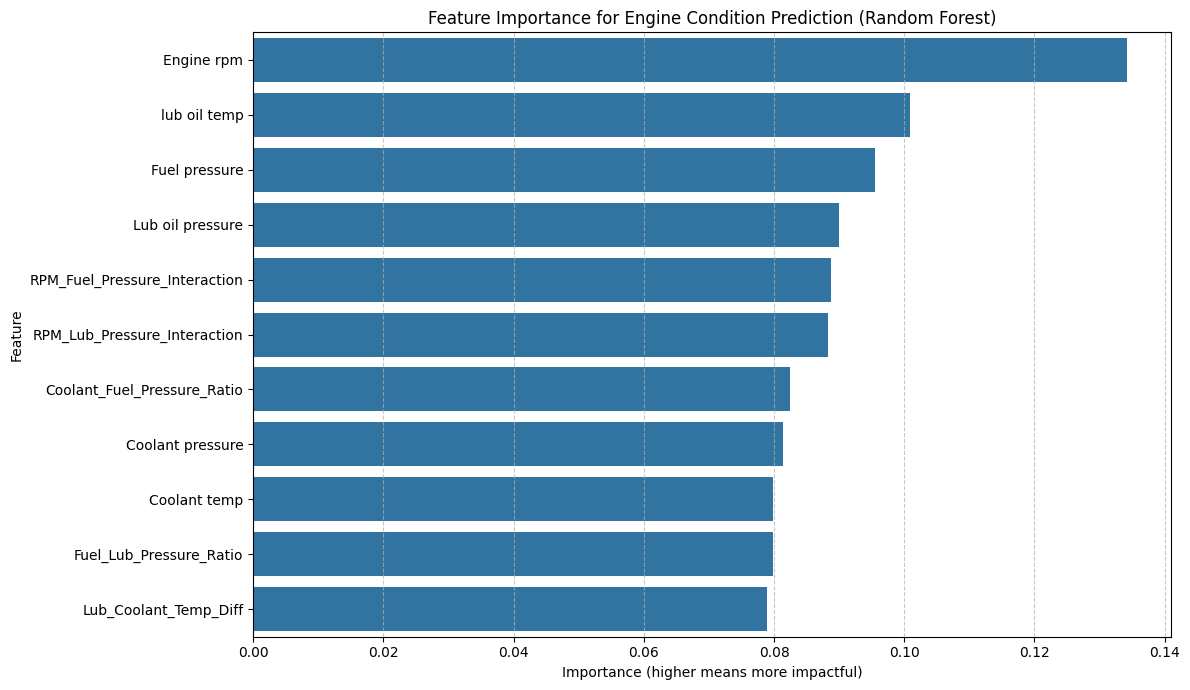

In [23]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(features_df)

# Visualize feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance for Engine Condition Prediction (Random Forest)')
plt.xlabel('Importance (higher means more impactful)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7707, number of negative: 4212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11919, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646615 -> initscore=0.604191
[LightGBM] [Info] Start training from score 0.604191

LightGBM model training complete.

LightGBM Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.48      0.63      0.54      1053
           1       0.76      0.63      0.69      1927

    accuracy                           0.63      2980
   macro avg       0.62      0.63      0.62      2980
weighted avg  

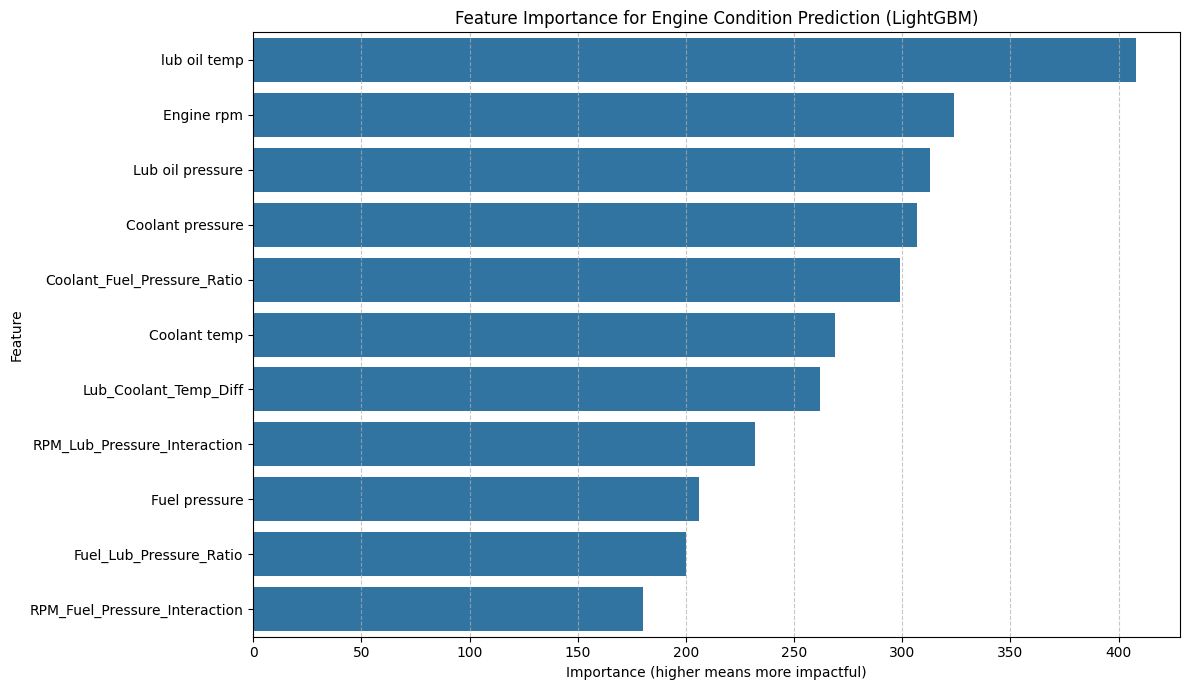

In [24]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

lgbm_model = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42, is_unbalance=True)

lgbm_model.fit(X_train_scaled_df, y_train)

print("\nLightGBM model training complete.")

# --- Evaluate the LightGBM Model ---
y_pred_lgbm = lgbm_model.predict(X_test_scaled_df)
y_proba_lgbm = lgbm_model.predict_proba(X_test_scaled_df)[:, 1] # Probability of class 1

print("\nLightGBM Classification Report on Test Set:")
print(classification_report(y_test, y_pred_lgbm))

print("\nLightGBM ROC AUC Score on Test Set:", roc_auc_score(y_test, y_proba_lgbm))

# --- Extract and Visualize Feature Importance for LightGBM ---
lgbm_feature_importances = lgbm_model.feature_importances_

# Create a DataFrame for better visualization
lgbm_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm_feature_importances
})

# Sort features by importance
lgbm_features_df = lgbm_features_df.sort_values(by='Importance', ascending=False)

print("\nLightGBM Feature Importances:")
print(lgbm_features_df)

# Visualize feature importances for LightGBM
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=lgbm_features_df)
plt.title('Feature Importance for Engine Condition Prediction (LightGBM)')
plt.xlabel('Importance (higher means more impactful)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import classification_report, roc_auc_score

# parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),  
    'learning_rate': uniform(0.01, 0.2), 
    'num_leaves': randint(20, 80),      
    'max_depth': randint(3, 15),        
    'min_child_samples': randint(10, 100), 
    'subsample': uniform(0.6, 0.4),     
    'colsample_bytree': uniform(0.6, 0.4), 
    'reg_alpha': uniform(0.0, 0.5),     
    'reg_lambda': uniform(0.0, 0.5)    
}

# Initialize the LightGBM Classifier
lgbm_clf = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42, is_unbalance=True)


random_search = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=param_dist,
    n_iter=50,  
    cv=5,       
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1   
)

print("Starting RandomizedSearchCV...")

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_scaled_df, y_train)

print("\nRandomizedSearchCV complete.")

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\nBest Hyperparameters found by RandomizedSearchCV:")
print(best_params)
print(f"\nBest ROC AUC Score on training data (cross-validation): {best_score:.4f}")

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7707, number of negative: 4212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11919, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646615 -> initscore=0.604191
[LightGBM] [Info] Start training from score 0.604191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

# Evaluation

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7707, number of negative: 4212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 11919, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.646615 -> initscore=0.604191
[LightGBM] [Info] Start training from score 0.604191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

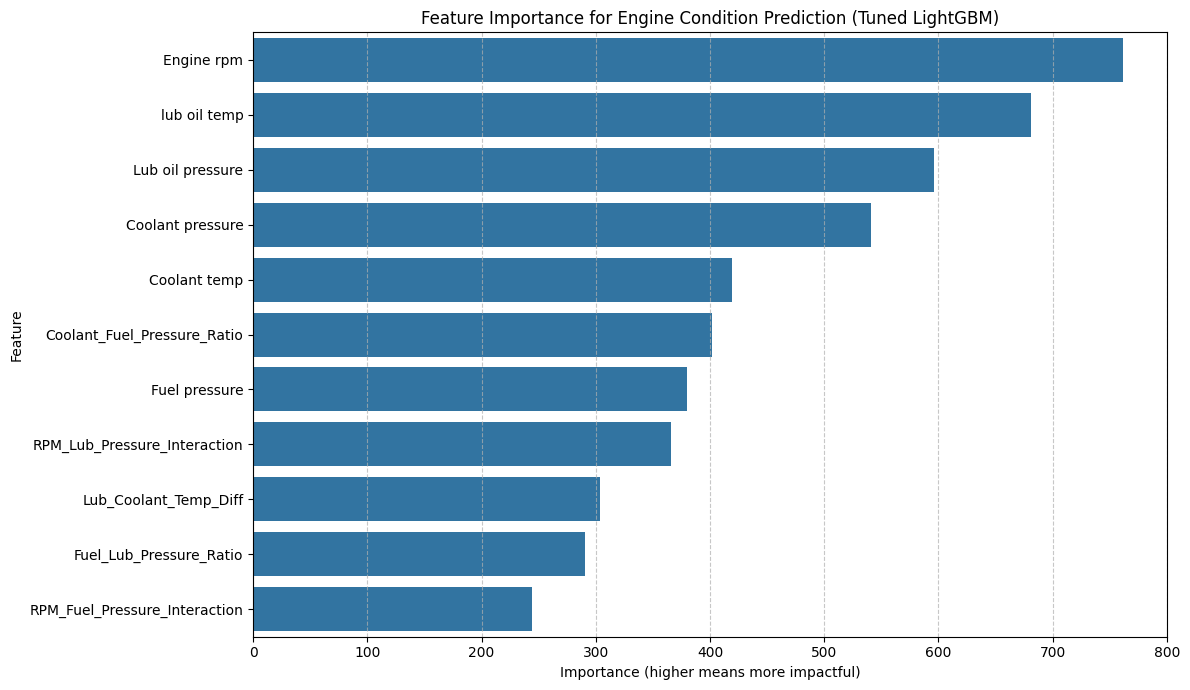

In [27]:
tuned_lgbm_model = lgb.LGBMClassifier(**best_params, objective='binary', metric='auc', random_state=42, is_unbalance=True)
tuned_lgbm_model.fit(X_train_scaled_df, y_train)

print("\nFinal LightGBM model (tuned) training complete.")

# Make predictions on the test set
y_pred_tuned_lgbm = tuned_lgbm_model.predict(X_test_scaled_df)
y_proba_tuned_lgbm = tuned_lgbm_model.predict_proba(X_test_scaled_df)[:, 1] # Probability of class 1

# Evaluate the tuned model
print("\n--- Tuned LightGBM Model Evaluation on Test Set ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned_lgbm))

print("\nROC AUC Score:", roc_auc_score(y_test, y_proba_tuned_lgbm))

# Extract and Visualize Feature Importance for Tuned LightGBM
tuned_lgbm_feature_importances = tuned_lgbm_model.feature_importances_

# Create a DataFrame for better visualization
tuned_lgbm_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tuned_lgbm_feature_importances
})

# Sort features by importance
tuned_lgbm_features_df = tuned_lgbm_features_df.sort_values(by='Importance', ascending=False)

print("\nTuned LightGBM Feature Importances:")
print(tuned_lgbm_features_df)

# Visualize feature importances for Tuned LightGBM
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=tuned_lgbm_features_df)
plt.title('Feature Importance for Engine Condition Prediction (Tuned LightGBM)')
plt.xlabel('Importance (higher means more impactful)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

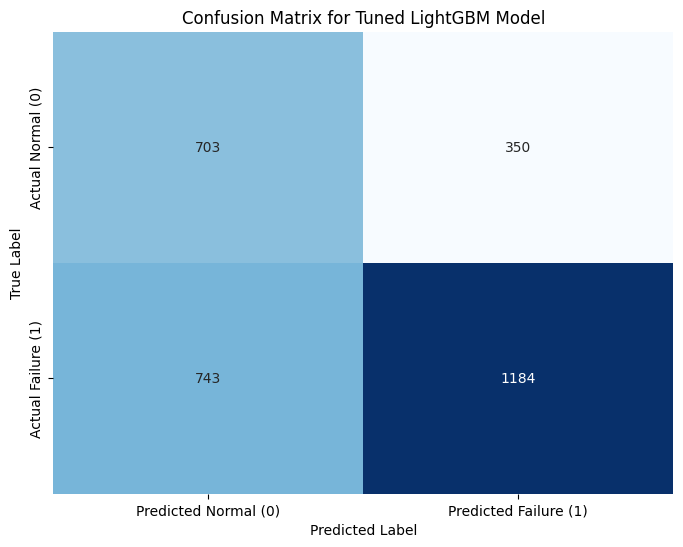


Confusion Matrix:
True Negative (Actual 0, Predicted 0): 703
False Positive (Actual 0, Predicted 1): 350
False Negative (Actual 1, Predicted 0): 743
True Positive (Actual 1, Predicted 1): 1184


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned_lgbm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Normal (0)', 'Predicted Failure (1)'],
            yticklabels=['Actual Normal (0)', 'Actual Failure (1)'])
plt.title('Confusion Matrix for Tuned LightGBM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the confusion matrix values for clarity
print("\nConfusion Matrix:")
print(f"True Negative (Actual 0, Predicted 0): {cm[0, 0]}")
print(f"False Positive (Actual 0, Predicted 1): {cm[0, 1]}")
print(f"False Negative (Actual 1, Predicted 0): {cm[1, 0]}")
print(f"True Positive (Actual 1, Predicted 1): {cm[1, 1]}")

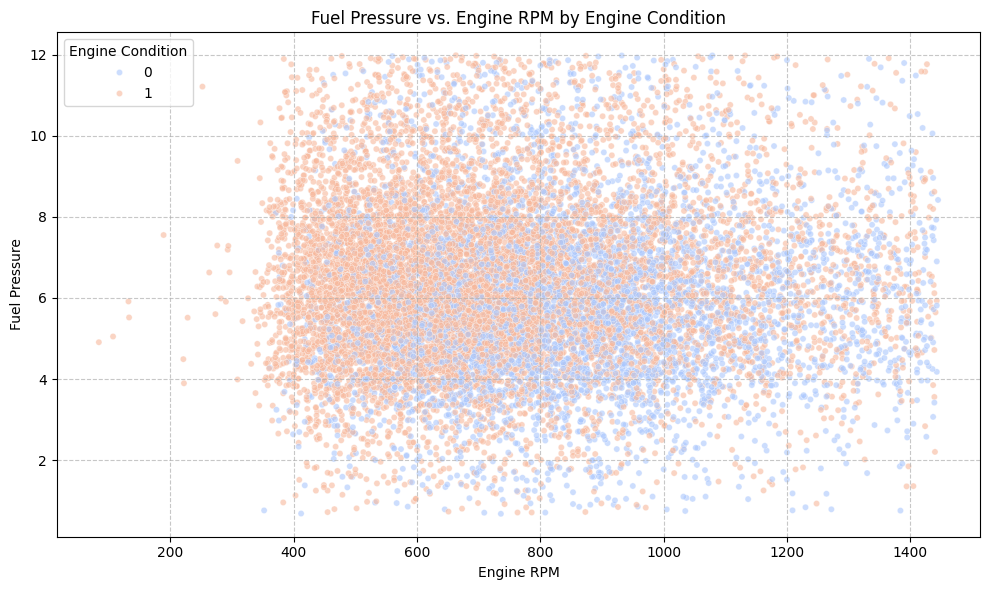

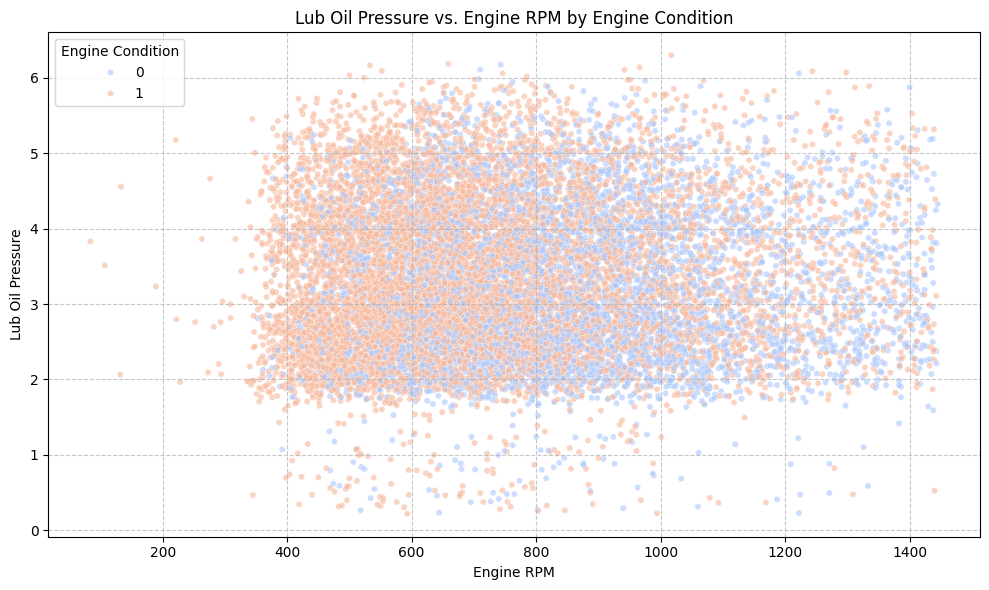

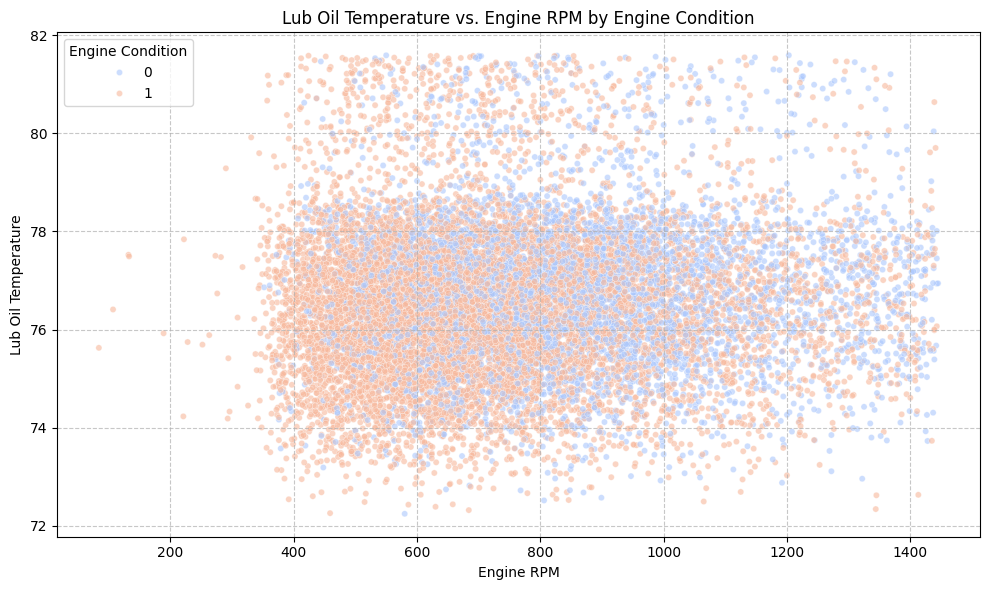

In [ ]:
data_path = '../Data/engine_data.csv'
df = pd.read_csv(data_path)

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

df_engineered = cleaned_df.copy()
df_engineered['Fuel_Lub_Pressure_Ratio'] = df_engineered['Fuel pressure'] / df_engineered['Lub oil pressure']
df_engineered['Coolant_Fuel_Pressure_Ratio'] = df_engineered['Coolant pressure'] / df_engineered['Fuel pressure']
df_engineered['Lub_Coolant_Temp_Diff'] = df_engineered['lub oil temp'] - df_engineered['Coolant temp']
df_engineered['RPM_Lub_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Lub oil pressure']
df_engineered['RPM_Fuel_Pressure_Interaction'] = df_engineered['Engine rpm'] * df_engineered['Fuel pressure']


# 1. Plot Fuel Pressure vs. Engine RPM, colored by Engine Condition
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Engine rpm', y='Fuel pressure', hue='Engine Condition',
                data=df_engineered, palette='coolwarm', alpha=0.6, s=20)
plt.title('Fuel Pressure vs. Engine RPM by Engine Condition')
plt.xlabel('Engine RPM')
plt.ylabel('Fuel Pressure')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Engine Condition')
plt.tight_layout()
plt.show()

# 2. Plot Lub Oil Pressure vs. Engine RPM, colored by Engine Condition
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Engine rpm', y='Lub oil pressure', hue='Engine Condition',
                data=df_engineered, palette='coolwarm', alpha=0.6, s=20)
plt.title('Lub Oil Pressure vs. Engine RPM by Engine Condition')
plt.xlabel('Engine RPM')
plt.ylabel('Lub Oil Pressure')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Engine Condition')
plt.tight_layout()
plt.show()

# 3. Plot Lub Oil Temp vs. Engine RPM, colored by Engine Condition
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Engine rpm', y='lub oil temp', hue='Engine Condition',
                data=df_engineered, palette='coolwarm', alpha=0.6, s=20)
plt.title('Lub Oil Temperature vs. Engine RPM by Engine Condition')
plt.xlabel('Engine RPM')
plt.ylabel('Lub Oil Temperature')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Engine Condition')
plt.tight_layout()
plt.show()

Data loaded, cleaned, and engineered features added successfully.
Shape of data after preprocessing: (14899, 12)


C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Engine Condition', y=feature, data=df_engineered, palette='coo

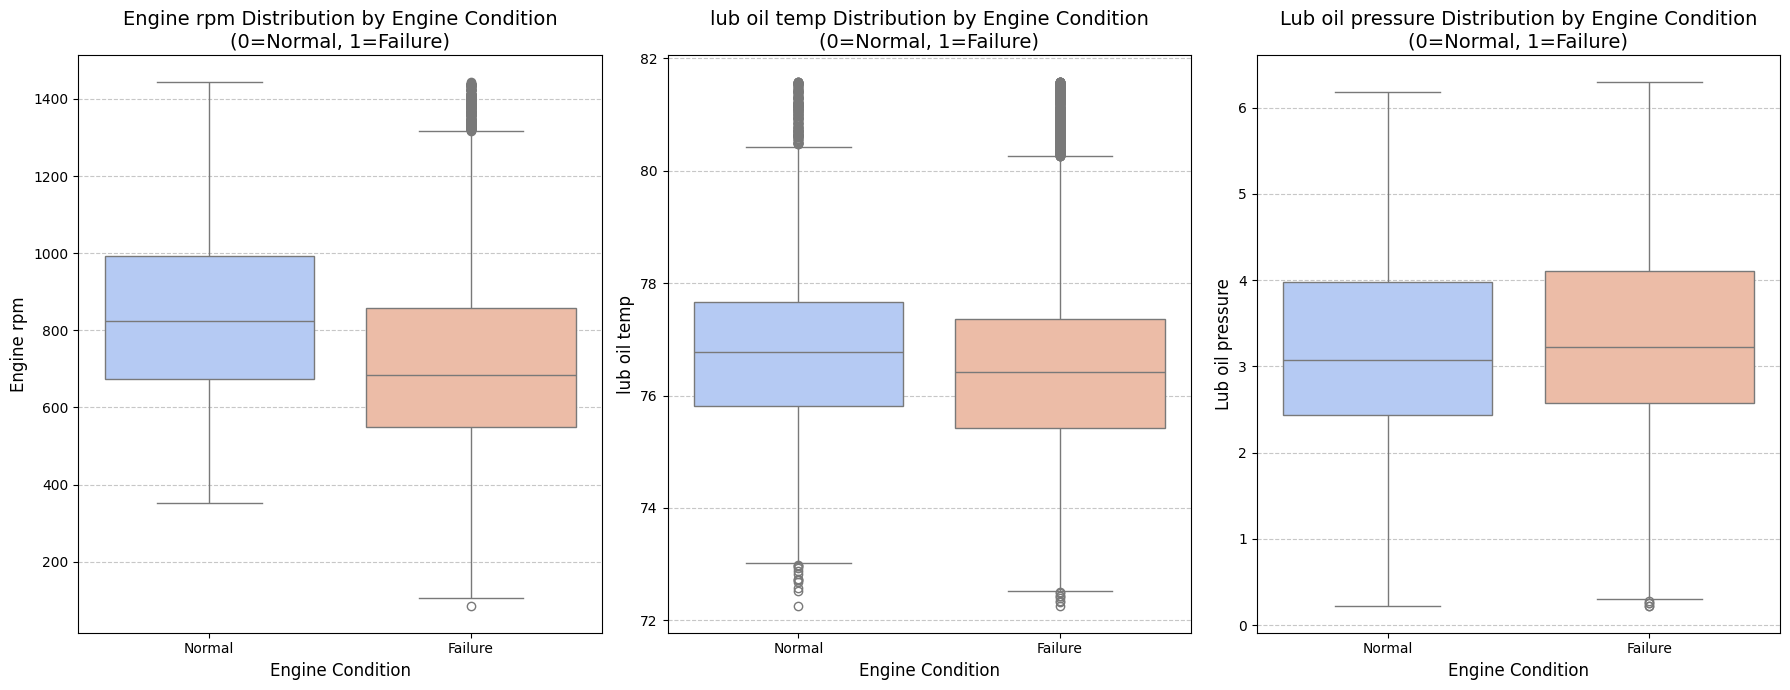

C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
C:\Users\deepa\AppData\Local\Temp\ipykernel_18004\39416651.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Engine Condition', y=feature, data=df_engineered, pal

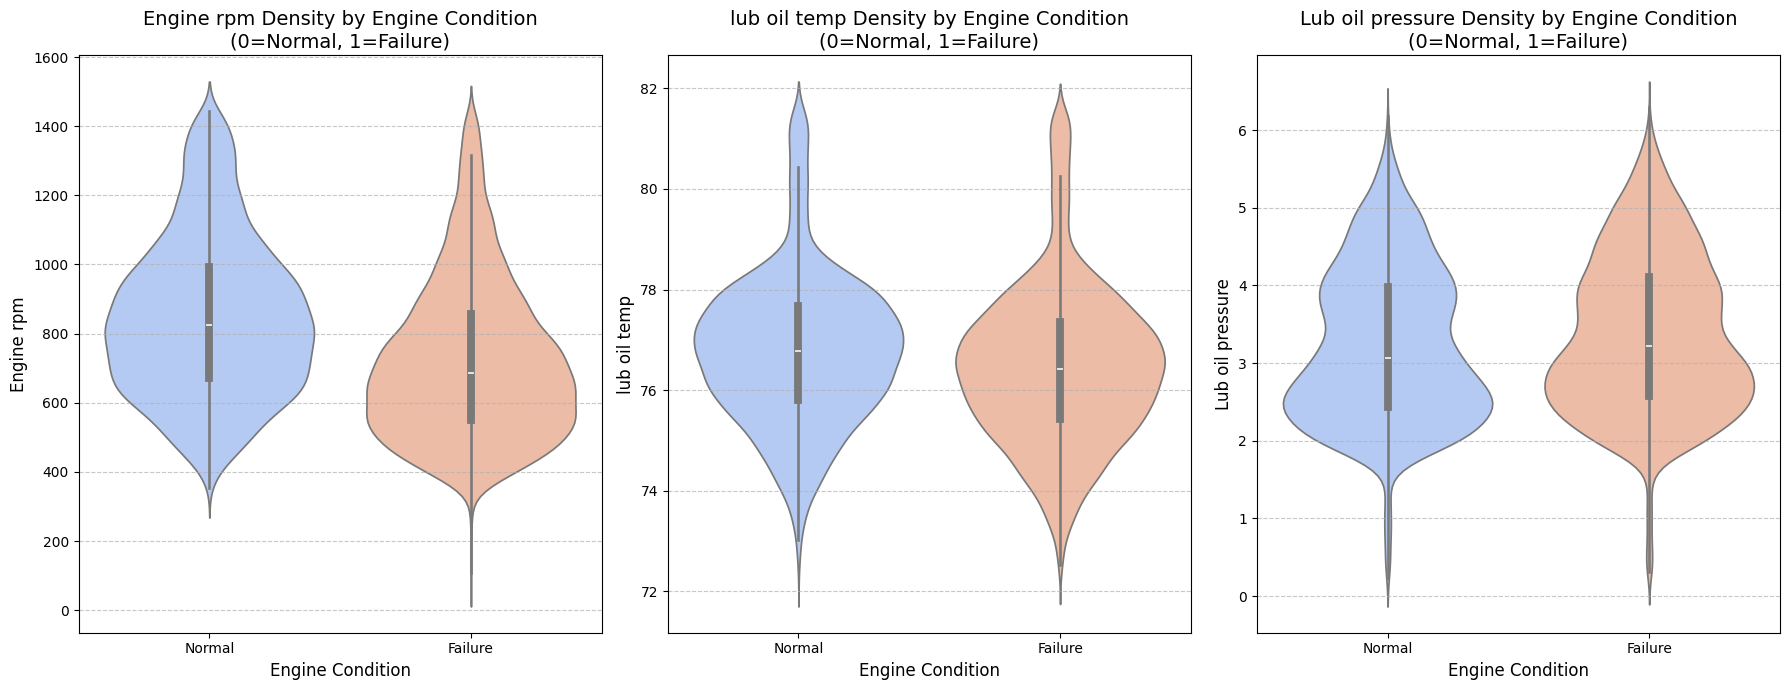

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '../Data/engine_data.csv'
df = pd.read_csv(data_path)

# Visualization for "Not Behaving Properly" Ranges

# Features to visualize their distribution by Engine Condition
features_to_plot = ['Engine rpm', 'lub oil temp', 'Lub oil pressure']

# Create Box Plots
plt.figure(figsize=(18, 7))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
    plt.title(f'{feature} Distribution by Engine Condition\n(0=Normal, 1=Failure)', fontsize=14)
    plt.xlabel('Engine Condition', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Normal', 'Failure']) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() 
plt.show()

plt.figure(figsize=(18, 7)) 

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.violinplot(x='Engine Condition', y=feature, data=df_engineered, palette='coolwarm')
    plt.title(f'{feature} Density by Engine Condition\n(0=Normal, 1=Failure)', fontsize=14)
    plt.xlabel('Engine Condition', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Normal', 'Failure']) # Custom x-axis labels
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Anomaly Detection using Isolation Forest: 
Number of anomalies detected by Isolation Forest (-1 label): 745

Isolation Forest Anomaly vs. Engine Condition (Original Label):
Engine Condition             0     1
iso_forest_anomaly_label            
-1                         340   405
 1                        4925  9229


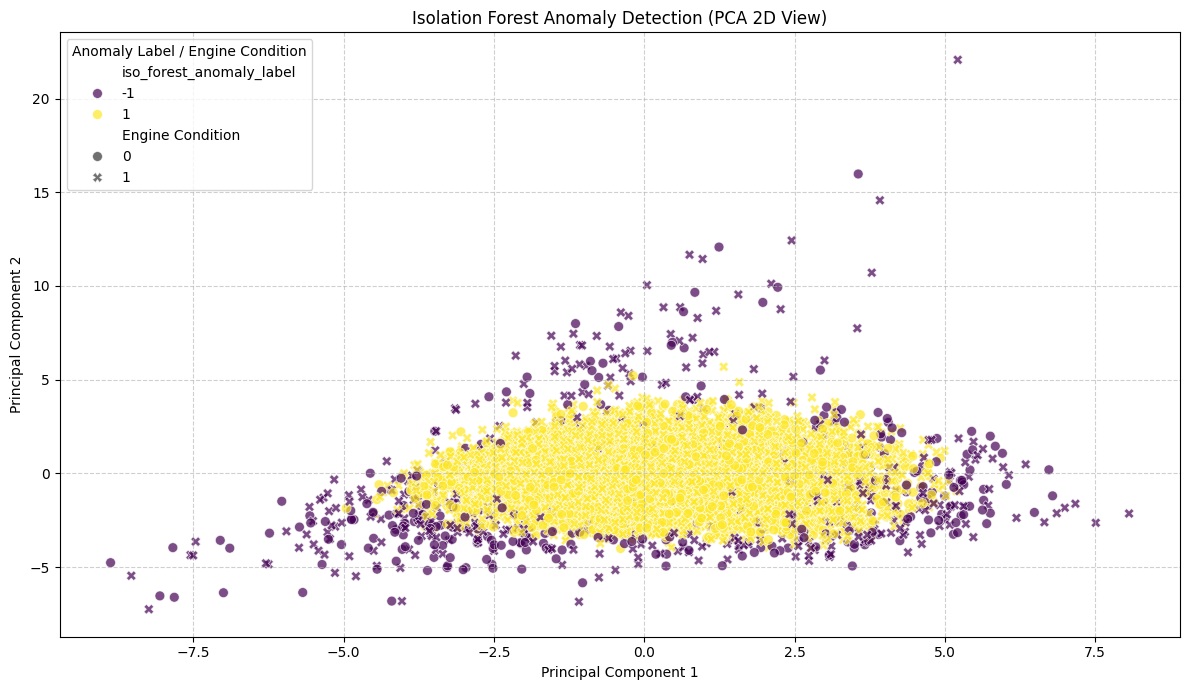

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

# Anomaly Detection using Isolation Forest 
print("\nAnomaly Detection using Isolation Forest: ")

iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
iso_forest.fit(X_scaled_df) # X_scaled_df contains your scaled features

# Predict anomaly scores and labels
df_engineered['iso_forest_anomaly_score'] = iso_forest.decision_function(X_scaled_df)
df_engineered['iso_forest_anomaly_label'] = iso_forest.predict(X_scaled_df)

print(f"Number of anomalies detected by Isolation Forest (-1 label): {(df_engineered['iso_forest_anomaly_label'] == -1).sum()}")

# Analyze how Isolation Forest anomalies correlate with known Engine Condition
print("\nIsolation Forest Anomaly vs. Engine Condition (Original Label):")
print(pd.crosstab(df_engineered['iso_forest_anomaly_label'], df_engineered['Engine Condition']))

# Visualization of Isolation Forest Anomalies 
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled_df)
df_pca_iso = pd.DataFrame(data=principal_components,
                           columns=['principal component 1', 'principal component 2'],
                           index=df_engineered.index)
df_pca_iso['iso_forest_anomaly_label'] = df_engineered['iso_forest_anomaly_label']
df_pca_iso['Engine Condition'] = df_engineered['Engine Condition'] 

plt.figure(figsize=(12, 7))
sns.scatterplot(x='principal component 1', y='principal component 2',
                hue='iso_forest_anomaly_label', 
                style='Engine Condition',       
                data=df_pca_iso, palette='viridis', s=50, alpha=0.7)
plt.title('Isolation Forest Anomaly Detection (PCA 2D View)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Anomaly Label / Engine Condition')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
